# Synthetic data generation

In [1]:
import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [2]:
from gluonts.dataset.artificial import recipe as rcp
from gluonts.core.serde import dump_code, load_code

In [3]:
# plotting utils

def plot_recipe(recipe, length):
    output_dict = rcp.evaluate(recipe, length)
    K = len(output_dict)
    lct = MultipleLocator(288)
    minor = AutoMinorLocator(12)

    fig, axs = plt.subplots(K, 1, figsize=(16, 2 * len(recipe)))
    for i, k in enumerate(output_dict):
        axs[i].xaxis.set_major_locator(lct)
        axs[i].xaxis.set_minor_locator(minor)
        axs[i].plot(output_dict[k])
        axs[i].grid()
        axs[i].set_ylabel(k)


def plot_examples(target, length, num, anomaly_indicator=None):
    fix, axs = plt.subplots(num, 1, figsize=(16, num * 2))
    for i in range(num):
        xx = rcp.evaluate(
            dict(
                target=target,
                anomaly_indicator=anomaly_indicator
            ), length)
        axs[i].plot(xx['target'])
        axs[i].set_ylim(0, 1.1*np.max(xx['target']))
        axs[i].grid()
        if anomaly_indicator is not None:
            axs[i].fill_between(
                np.arange(len(xx['target'])), 
                xx['anomaly_indicator'] * 1.1*np.max(xx['target']), 
                np.zeros(len(xx['target'])), 
                alpha=0.3,
                color="red")


def print_dicts(*dicts):
    for d in dicts:
        print("{")
        for k,v in d.items():
            print("\t", k, ": ", v)
        print("}\n")

## Data Generation Recipes

To generate realistic artificial data, we describe the data generation process through a symbolic graph (this is akin to how mxnet symbol graphs work).

Your graph can contain python values as well as operators that correspond to random variables or random processes. The output of a recipe can be a list, dictionary or a value:

In [4]:
rcp.evaluate(rcp.RandomGaussian(), length=5)

array([ 1.09011751,  0.04582359, -0.30879158,  0.36234547, -0.45457739])

In [5]:
rcp.evaluate({
    'var1': rcp.RandomGaussian(),
    'var2': 3.0
}, length=5)

{'var1': array([-0.54635298, -1.11448726,  0.32567069,  0.56784008, -0.45826187]),
 'var2': 3.0}

In [6]:
rcp.evaluate(
    [3.0, rcp.RandomUniform()]
, length=5)

[3.0, array([0.22607576, 0.4375824 , 0.02716331, 0.38102183, 0.37640134])]

In [7]:
recipe = dict(
    myOutput1=rcp.RandomGaussian()
)

# multiple evaluations lead to different results, due to randomness
print_dicts(
    rcp.evaluate(recipe, length=5),
    rcp.evaluate(recipe, length=5),
)

{
	 myOutput1 :  [ 0.42151209 -1.00661509  0.20625425  0.20666595 -0.61857058]
}

{
	 myOutput1 :  [-0.40078741  0.33110249 -0.53316541  0.56169378 -0.38260157]
}



### Referencing variables

Each time you create a random variable such as `RandomGaussian` the variable refers to a new independent RV.
You can re-use and refer to previously created random variables.

In [8]:
stddev1 = 2.0
stddev2 = rcp.RandomUniform(low=0, high=1, shape=(1, ))
x1 = rcp.RandomGaussian(stddev=stddev1)
x2 = rcp.RandomGaussian(stddev=stddev2)
x3 = 2 * x2

recipe = dict(
    x1=x1,
    x2=x2,
    x3=x3
)

# multiple evaluations lead to different results, due to randomness
print_dicts(
    rcp.evaluate(recipe, length=5),
    rcp.evaluate(recipe, length=5)
)

{
	 x1 :  [-3.94810714  0.92523896 -1.18017073  2.32449885 -0.26686527]
	 x2 :  [ 0.31829819  0.30103276  1.09221714 -0.36075908  0.76565555]
	 x3 :  [ 0.63659638  0.60206551  2.18443429 -0.72151816  1.5313111 ]
}

{
	 x1 :  [-1.2290257   2.43602476  5.85091652  4.18485991  2.48448249]
	 x2 :  [-0.41392585  0.43105209  0.14964795 -0.03055409 -0.21716438]
	 x3 :  [-0.8278517   0.86210418  0.29929591 -0.06110818 -0.43432876]
}



Note that you may create and use intermediate random varibles such as `stddev2` in the above example without including them in the output.

In [9]:
recipe = dict(
    random_out=rcp.RandomGaussian(shape=(1,)),
    fixed_out=np.random.randn(1)
)

# note that fixed_out stays the same; 
# it's evaluated only once when the recipe is created
print_dicts(
    rcp.evaluate(recipe, length=1),
    rcp.evaluate(recipe, length=1)
)

{
	 random_out :  [-0.97446994]
	 fixed_out :  [-0.01612317]
}

{
	 random_out :  [0.83518873]
	 fixed_out :  [-0.01612317]
}



### Length

Most operators in the `recipe` package have a `length` argument that is automatically passed when the expression is evaluated. The idea is that these recipes are used to generate fixed-length time series, and most operators produce
individual components of the time series that have the same length.

In [10]:
recipe = dict(
    random_gaussian=rcp.RandomGaussian(),
    constant_vec=rcp.ConstantVec(42)
    
)

print_dicts(
    rcp.evaluate(recipe, length=3),
    rcp.evaluate(recipe, length=5)
)

{
	 random_gaussian :  [-1.29960485  0.6004166  -0.28741941]
	 constant_vec :  [42. 42. 42.]
}

{
	 random_gaussian :  [-1.41924117 -1.88469093  0.76382044 -0.11253277 -0.73872854]
	 constant_vec :  [42. 42. 42. 42. 42.]
}



### Operator Overloading

The operators defined in the `recipe` package overload the basic arithmetic operations (addition, subtraction, multiplication, division).

In [11]:
x1 = 42 * rcp.ConstantVec(1)
x2 = x1 * rcp.RandomUniform()
x3 = rcp.RandomGaussian() + rcp.RandomUniform()
result = x1 + x2 + x3

rcp.evaluate(result, 3)

array([72.62161111, 63.3546109 , 83.61042208])

### SerDe

Recipes composed of serializable / representable components can easily be serialized / deserialized.

In [12]:
dumped = dump_code(result)
print(dumped)

reconstructed = load_code(dumped)

rcp.evaluate(reconstructed, 3)

gluonts.dataset.artificial.recipe._LiftedBinaryOp(left=gluonts.dataset.artificial.recipe._LiftedBinaryOp(left=gluonts.dataset.artificial.recipe._LiftedBinaryOp(left=42, op="*", right=gluonts.dataset.artificial.recipe.ConstantVec(constant=1)), op="+", right=gluonts.dataset.artificial.recipe._LiftedBinaryOp(left=gluonts.dataset.artificial.recipe._LiftedBinaryOp(left=42, op="*", right=gluonts.dataset.artificial.recipe.ConstantVec(constant=1)), op="*", right=gluonts.dataset.artificial.recipe.RandomUniform(high=1.0, low=0.0, shape=(0,)))), op="+", right=gluonts.dataset.artificial.recipe._LiftedBinaryOp(left=gluonts.dataset.artificial.recipe.RandomGaussian(shape=(0,), stddev=1.0), op="+", right=gluonts.dataset.artificial.recipe.RandomUniform(high=1.0, low=0.0, shape=(0,))))


array([73.39210847, 57.14837092, 83.35762422])

## Simple Examples

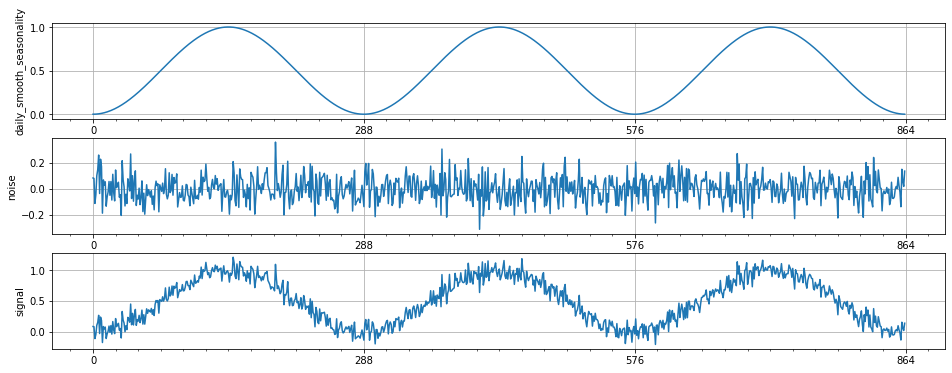

In [13]:
daily_smooth_seasonality = rcp.SmoothSeasonality(period=288, phase=-72)
noise = rcp.RandomGaussian(stddev=0.1)
signal = daily_smooth_seasonality + noise

recipe = dict(
    daily_smooth_seasonality=daily_smooth_seasonality,
    noise=noise,
    signal=signal
)

plot_recipe(recipe, 3 * 288)

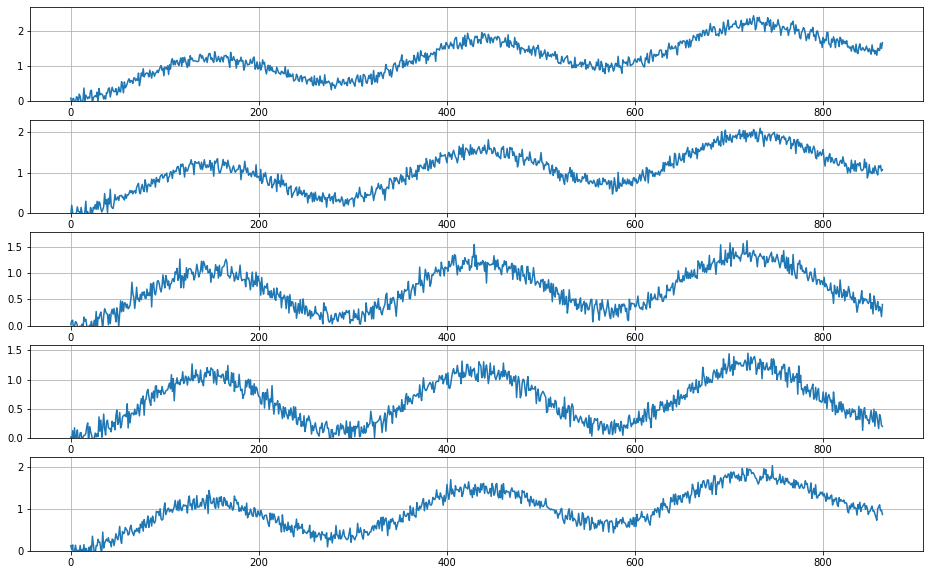

In [14]:
slope = rcp.RandomUniform(low=0, high=3, shape=(1,))
trend = rcp.LinearTrend(slope=slope)
daily_smooth_seasonality = rcp.SmoothSeasonality(period=288, phase=-72)
noise = rcp.RandomGaussian(stddev=0.1)
signal = trend + daily_smooth_seasonality + noise

plot_examples(signal, 3 * 288, 5)

## Composing Recipes

There are many ways to combine and extend generation recipes. For example using python functions.

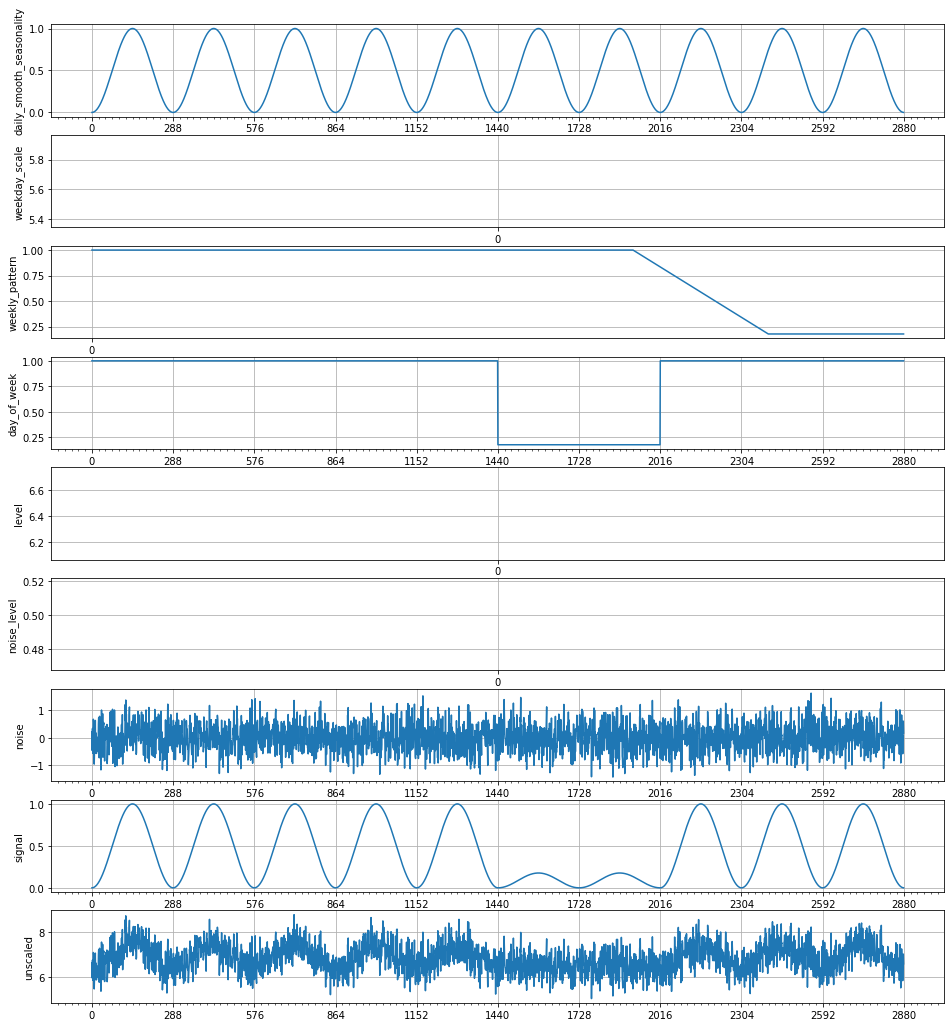

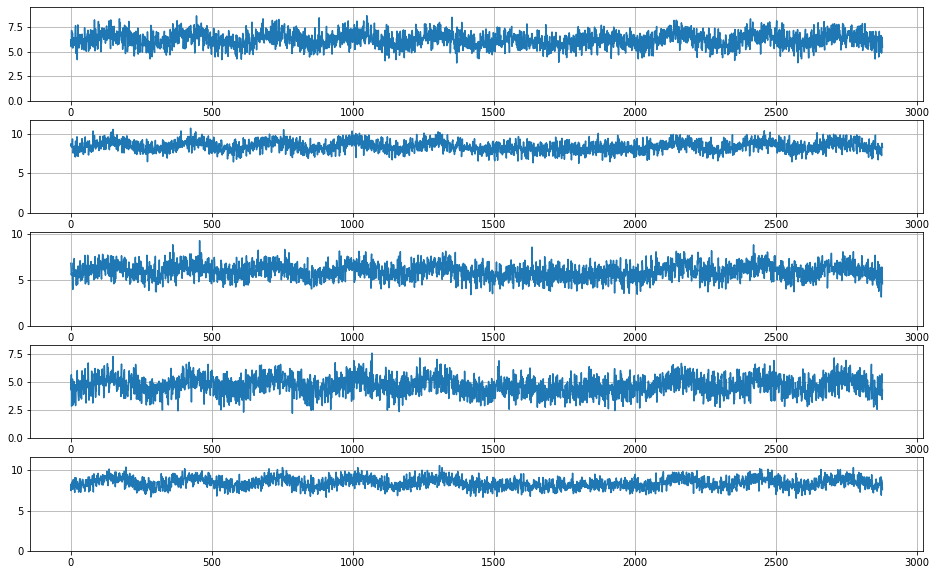

In [15]:
def weekly_seasonal_unscaled():
    daily_smooth_seasonality = rcp.SmoothSeasonality(period=288, phase=-72)
    weekday_scale = rcp.RandomUniform(0.1, 10, shape=(1,))
    weekly_pattern = rcp.NormalizeMax(rcp.Concatenate([weekday_scale * np.ones(5), np.ones(2)]))
    day_of_week = rcp.Dilated(rcp.Repeated(weekly_pattern), 288)
    level = rcp.RandomUniform(low=0, high=10, shape=1)
    noise_level = rcp.RandomUniform(low=0.01, high=1, shape=1)
    noise = noise_level * rcp.RandomGaussian()
    signal = daily_smooth_seasonality * day_of_week
    unscaled = level + signal + noise

    return dict(
        daily_smooth_seasonality=daily_smooth_seasonality,
        weekday_scale=weekday_scale,
        weekly_pattern=weekly_pattern,
        day_of_week=day_of_week,
        level=level,
        noise_level=noise_level,
        noise=noise,
        signal=signal,
        unscaled=unscaled
    )

recipe = weekly_seasonal_unscaled()
plot_recipe(recipe, 10 * 288)
    
plot_examples(recipe['unscaled'], 10 * 288, 5)

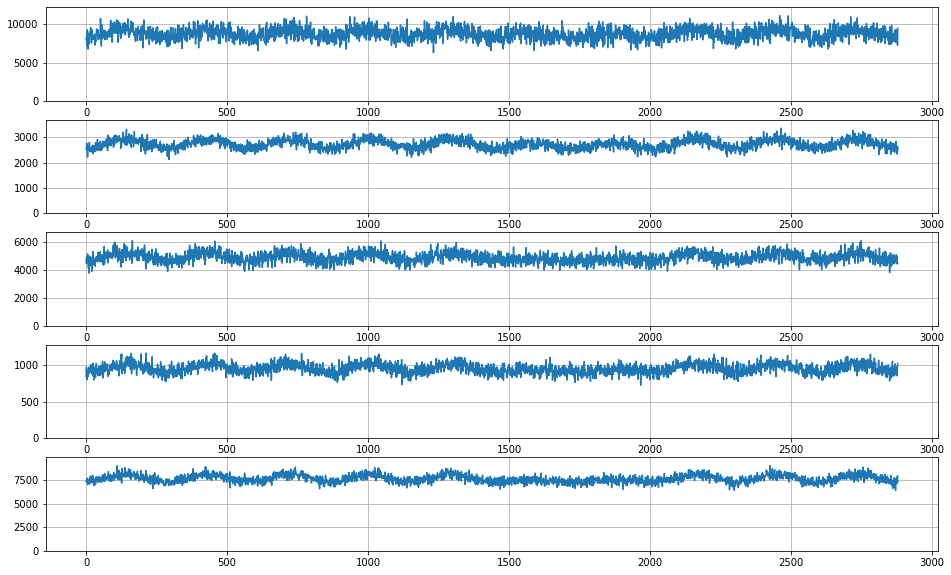

In [16]:
def weekly_seasonal():
    c = weekly_seasonal_unscaled()
    unscaled = c['unscaled']

    scale = rcp.RandomUniform(low=0, high=1000, shape=1)
    z = scale * unscaled
    return z
    
plot_examples(weekly_seasonal(), 10 * 288, 5)

Here is a more complex example

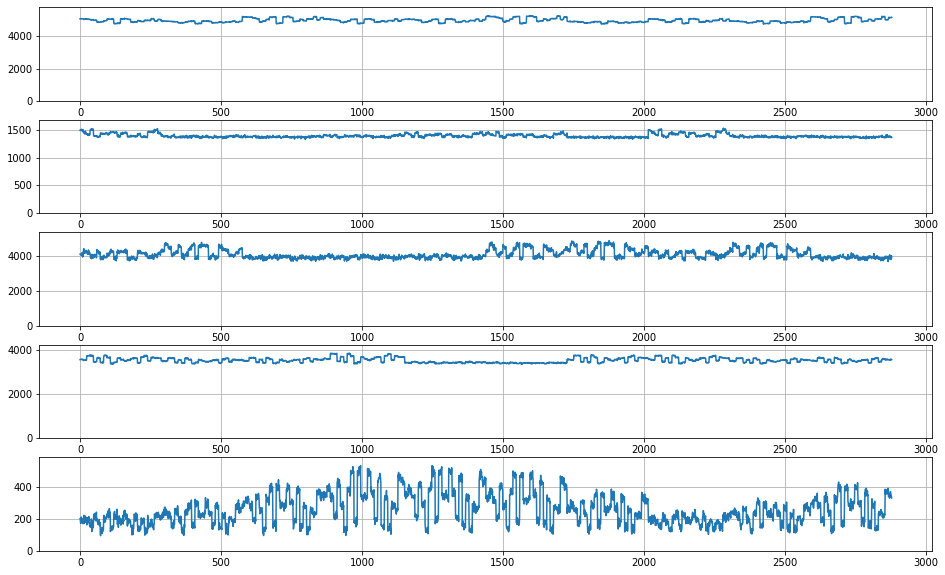

In [17]:
def scale(unscaled):
    s = rcp.RandomUniform(low=0, high=1000, shape=1)
    z = s * unscaled
    return z
    

def complex_weekly_seasonality():
    daily_pattern = rcp.RandomUniform(0, 1, shape=(24,))
    daily_seasonality = rcp.Dilated(rcp.Repeated(daily_pattern), 12)
    weekly_pattern = rcp.RandomUniform(0, 1, shape=(7,))
    weekly_seasonality = rcp.Dilated(rcp.Repeated(weekly_pattern), 288)
    unnormalized_seasonality = daily_seasonality * weekly_seasonality
    seasonality = rcp.NormalizeMax(unnormalized_seasonality)

    noise_level = rcp.RandomUniform(low=0.01, high=0.1, shape=1)
    noise = noise_level * rcp.RandomGaussian()

    level = rcp.RandomUniform(low=0, high=10, shape=1)
    signal = level + seasonality

    unscaled = signal + noise
    return scale(unscaled)

plot_examples(complex_weekly_seasonality(), 10 * 288, 5)

## Generating Anomalies

Anomalies are just another effect added/multiplied to a base time series. We can define a recipe for creating certain types of anomalies, and then compose it with a base recipe.

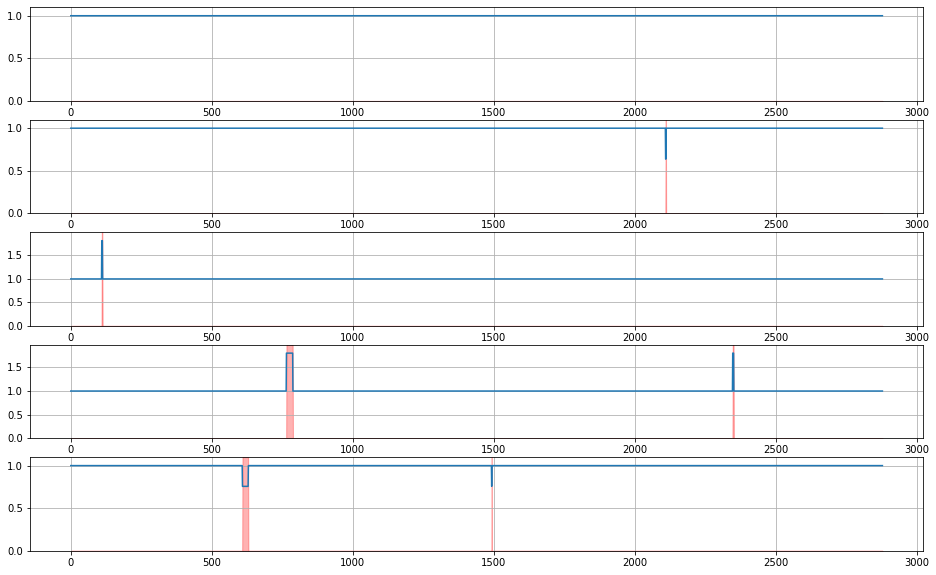

In [18]:
z = rcp.ConstantVec(1.0)

def inject_anomalies(z):
    normal_indicator = rcp.BinaryMarkovChain(one_to_zero=1/(288*7), zero_to_one=0.1)
    anomaly_indicator = 1 - normal_indicator
    anomaly_scale = 0.5 + rcp.RandomUniform(-1.0, 1.0, shape=1)
    anomaly_multiplier = 1 + anomaly_scale * anomaly_indicator
    target = z * anomaly_multiplier
    return target, anomaly_indicator

target, anomaly_indicator = inject_anomalies(z)
plot_examples(target, 10*288, 5, anomaly_indicator)

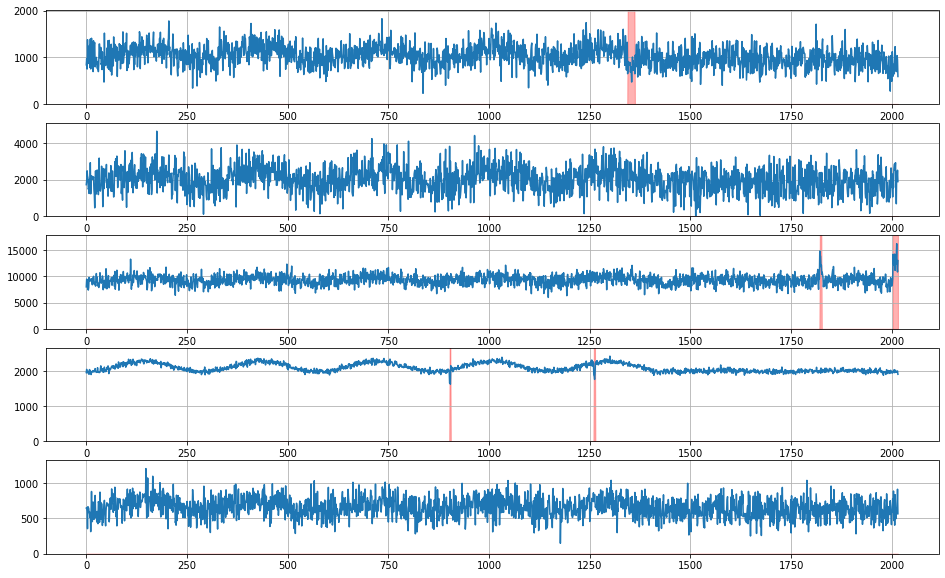

In [19]:
target, anomaly_indicator = inject_anomalies(weekly_seasonal())
plot_examples(target, 288*7, 5, anomaly_indicator)

## Generating Changepoints

In [20]:
level = rcp.RandomUniform(0, 10, shape=1)
noise_level = rcp.RandomUniform(0.01, 1, shape=1)
noise =  rcp.RandomGaussian(noise_level)
homoskedastic_gaussian_noise = level + noise

In [21]:
z1 = homoskedastic_gaussian_noise
z2 = weekly_seasonal_unscaled()['unscaled']
z_stacked = rcp.Stack([z1, z2])
change = rcp.RandomChangepoints(1)
unscaled = rcp.Choose(z_stacked, change)

target = scale(unscaled)
target, anomaly_indicator = inject_anomalies(target)


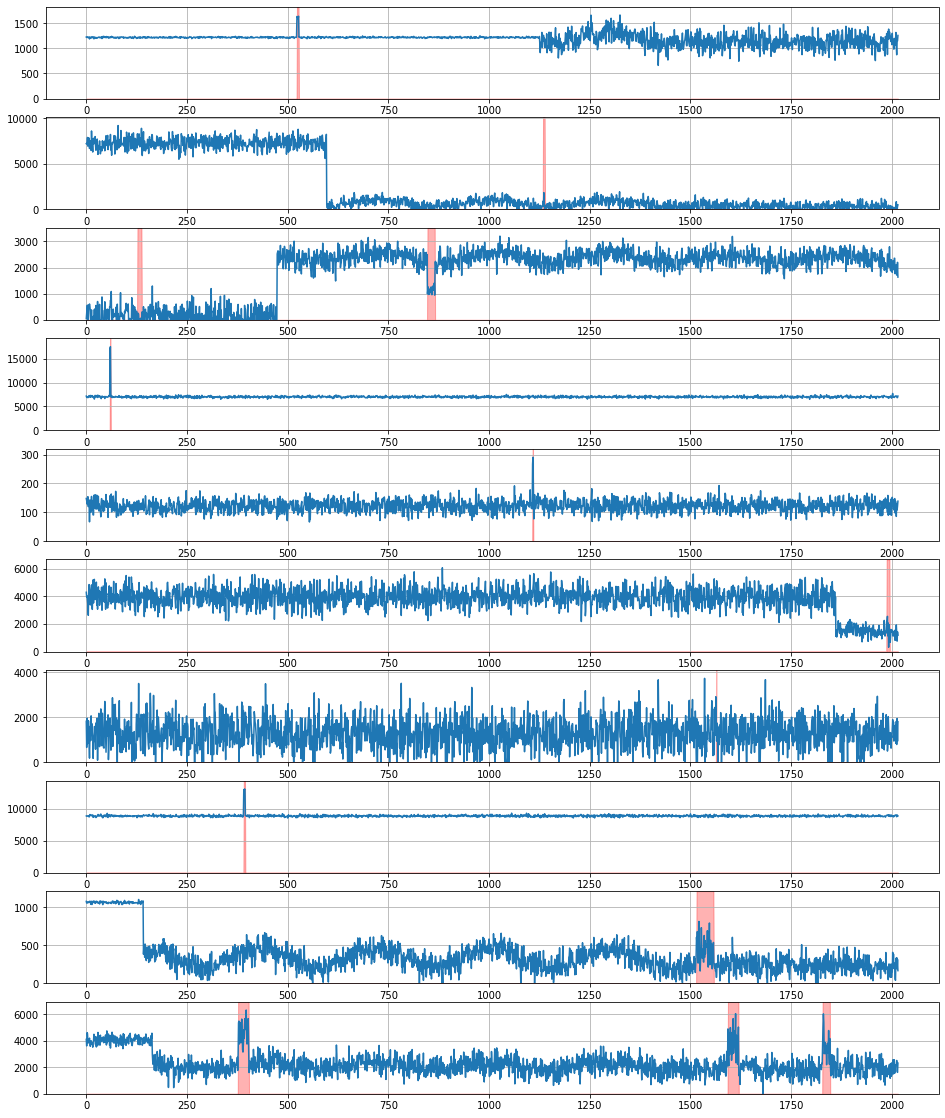

In [22]:
plot_examples(target, 288*7, 10, anomaly_indicator)

## Generating several time series

In [23]:
rcp.take_as_list(rcp.generate(10, weekly_seasonal_unscaled(), "2018-01-01", {}), 2)

[{'daily_smooth_seasonality': array([0.        , 0.00011899, 0.00047589, 0.00107054, 0.00190265,
         0.00297183, 0.00427757, 0.00581924, 0.00759612, 0.00960736]),
  'weekday_scale': array([5.53325369]),
  'weekly_pattern': array([1.        , 1.        , 1.        , 1.        , 1.        ,
         0.18072549, 0.18072549]),
  'day_of_week': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'level': array([7.15189366]),
  'noise_level': array([0.60673574]),
  'noise': array([-1.37627579,  0.80910965, -0.5113108 ,  1.19522357,  0.76819937,
         -0.30693338,  1.54426428,  0.65576722,  0.29384949,  0.35138523]),
  'signal': array([0.        , 0.00011899, 0.00047589, 0.00107054, 0.00190265,
         0.00297183, 0.00427757, 0.00581924, 0.00759612, 0.00960736]),
  'unscaled': array([5.77561787, 7.9611223 , 6.64105875, 8.34818777, 7.92199568,
         6.84793212, 8.70043552, 7.81348013, 7.45333928, 7.51288625]),
  'item_id': '0',
  'start': '2018-01-01'},
 {'daily_smooth_seasonality':

## Saving to a file

In [24]:
def write_to_file(recipe, length, num_ts, fields, fn):
    with open(fn, 'w') as f, open(fn+"-all", 'w') as g:
        for x in islice(rcp.generate(length, recipe, "2019-01-07 00:00"), num_ts):
            z = {}
            for k in x:
                if type(x[k]) == np.ndarray:
                    z[k] = x[k].tolist()
                else:
                    z[k] = x[k]
            xx = {}
            for fi in fields:
                xx[fi] = z[fi]
            try:
                f.write(json.dumps(xx))
            except Exception as e:
                print(xx)
                print(z)
                raise e
            f.write('\n')
            g.write(json.dumps(z))
            g.write('\n')